In [94]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
import cv2
import torch.distributions as td
from lib.generate_mask import GenerateMask

In [95]:
random_seed = 111
origin_dataset = torch.load('moving_minst_data.pt')
total_data_len = len(origin_dataset)
p_miss_num_perc, p_miss_perc, t_miss_num_perc = (0.4,0.8,0.4)

In [96]:
g_m = GenerateMask(random_seed)
masks = g_m.generate_random_masks(total_data_len,p_miss_num_perc*total_data_len,t_miss_num_perc*total_data_len,p_miss_perc,(origin_dataset[0].size(-2),origin_dataset[0].size(-1)))
torch.save(masks,'moving_minst_data_masks.pt')

In [97]:
masks = torch.load('moving_minst_data_masks.pt')
dataset=origin_dataset*masks
dataset_m = torch.cat((dataset,masks),dim=1)

In [98]:
m=len(dataset)
full_data, full_val_data = random_split(origin_dataset, [int(m-m*0.2), int(m*0.2)],generator=torch.Generator().manual_seed(random_seed))
train_data, val_data = random_split(dataset_m, [int(m-m*0.2), int(m*0.2)],generator=torch.Generator().manual_seed(random_seed))
batch_size=256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

In [99]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size, stride, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size, stride, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size, stride, padding=1)  
        self.conv4 = nn.Conv2d(64, 128, kernel_size, stride, padding=1)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size, stride, padding=1)
        self.linear1 = nn.Linear(256*2*2, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = td.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
        x = x.to(device)


        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.batch3(self.conv4(x)))
        x = F.relu(self.conv5(x))
      
        x = torch.flatten(x, start_dim=1)
        
        x = F.relu(self.linear1(x))

        mu =  self.linear2(x)
        log_var = self.linear3(x)
        sigma = torch.exp(0.5 * log_var)
        
        rand_state = torch.random.get_rng_state()[0]
        torch.random.manual_seed(rand_state+1)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl=-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(),dim=1)
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z   
    

In [100]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 256*2*2),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 2, 2))

        self.decoder_conv = nn.Sequential(

            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size, stride, padding=1, output_padding=1),
            nn.Upsample(size=(64,64))
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        
        x = torch.sigmoid(x)
        return x


In [101]:
class GaussianDecoder(Decoder):
    def forward(self, x):
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)

        x = torch.sigmoid(x)
       
        var = torch.ones_like(x)
        
        return td.Normal(loc=x, scale=var)

In [102]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = GaussianDecoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [103]:
### Set the random seed for reproducible results
torch.manual_seed(random_seed)

kernel_size = [3,3]
stride=[2,2]

d = 20

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=1024, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=20, bias=True)
    (linear3): Linear(in_features=128, out_features=20, bias=True)
  )
  (decoder): GaussianDecoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU(inplace=Tr

In [104]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for data in dataloader: 
        # Move tensor to the proper device
        x = data[:,:1,:,:]
        mask = data[:,1:,:,:]
        x = x.to(device)
        mask = mask.to(device)
        px_z = vae(x)
        
        # Evaluate loss
        # if all zero in a mask, change back to 1
        temp_mask = mask.squeeze().flatten(1,2)
        mask_sum = temp_mask.sum(1)
        boolen_mask = (mask_sum ==0)
        temp_mask[boolen_mask] = 1
        temp_mask = temp_mask.reshape(mask.shape)

    
      

        nll = (-px_z.log_prob(x)*mask).sum((1,2,3)).mean()

        kl = vae.encoder.kl.mean()

        loss = nll + kl*0.1
        # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
      
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        nll_loss += nll.item()
        kl_loss += kl.item()

        train_loss+=loss.item()
        

    return train_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader)

In [105]:
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for data in dataloader:
            # Move tensor to the proper device
            x = data[:,:1,:,:]
            mask = data[:,1:,:,:]
            x = x.to(device)
            mask = mask.to(device)
            px_z = vae(x)
        


            # temp_mask = mask.squeeze().flatten(1,2)
            # mask_sum = temp_mask.sum(1)
            # boolen_mask = (mask_sum ==0)
            # temp_mask[boolen_mask] = 1
            # temp_mask = temp_mask.reshape(mask.shape)
           
            # Encode data
            # encoded_data = vae.encoder(x)
            # decoded_data = vae.decoder(encoded_data)
            # print(decoded_data.size())
            # Decode data
            
        # Evaluate loss
            nll = (-px_z.log_prob(x)).sum((1,2,3)).mean()

            kl = vae.encoder.kl.mean()

            loss = nll + kl*0.1
            
            
            # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            nll_loss += nll.item()
            kl_loss += kl.item()

          
            val_loss += loss.item()

    return val_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader)

In [106]:
def plot_ae_outputs(encoder,decoder,n=10):
    fig, axs = plt.subplots(10, 2,figsize=(30,100))
    # targets = [item[0] for item in test_data]
    # t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    i=0
    random.seed(random_seed)
    for index in random.sample(range(len(val_data)), n):
      img = val_data[index][:1].unsqueeze(0).to(device)
      
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img)).mean
         print(encoder(img))
      axs[i,0].imshow(img.cpu().squeeze().numpy(), cmap='gray')
      
      axs[i,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')
      i=i+1

In [107]:
num_epochs = 200

train_loss_sum = []
train_nll_sum = []
train_kl_sum = []
val_loss_sum = []
val_nll_sum = []
val_kl_sum = []
for epoch in range(num_epochs):
   train_loss,train_nll_loss,train_kl_loss = train_epoch(vae,device,train_loader,optim)
   val_loss,val_nll_loss,val_kl_loss = test_epoch(vae,device,valid_loader)
   train_loss_sum.append(train_loss)
   train_nll_sum.append(train_nll_loss)
   train_kl_sum.append(train_kl_loss)
   val_loss_sum.append(val_loss)
   val_nll_sum.append(val_nll_loss)
   val_kl_sum.append(val_kl_loss)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t train nll loss {:.3f} \t train kl loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,train_nll_loss,train_kl_loss))
   print('\n val loss {:.3f} \t val nll loss {:.3f} \t val kl loss {:.3f}'.format(val_loss,val_nll_loss,val_kl_loss))
   # plot_ae_outputs(vae.encoder,vae.decoder,n=10)


 EPOCH 1/200 	 train loss 2777.395 	 train nll loss 2777.322 	 train kl loss 0.729

 val loss 4090.757 	 val nll loss 4090.752 	 val kl loss 0.045

 EPOCH 2/200 	 train loss 2665.308 	 train nll loss 2665.187 	 train kl loss 1.207

 val loss 3928.237 	 val nll loss 3928.127 	 val kl loss 1.106

 EPOCH 3/200 	 train loss 2612.025 	 train nll loss 2611.454 	 train kl loss 5.713

 val loss 3919.730 	 val nll loss 3919.493 	 val kl loss 2.370

 EPOCH 4/200 	 train loss 2581.556 	 train nll loss 2580.983 	 train kl loss 5.731

 val loss 3887.232 	 val nll loss 3886.840 	 val kl loss 3.918

 EPOCH 5/200 	 train loss 2566.858 	 train nll loss 2566.363 	 train kl loss 4.948

 val loss 3877.124 	 val nll loss 3876.667 	 val kl loss 4.570

 EPOCH 6/200 	 train loss 2558.456 	 train nll loss 2557.868 	 train kl loss 5.880

 val loss 3869.695 	 val nll loss 3869.207 	 val kl loss 4.888

 EPOCH 7/200 	 train loss 2552.913 	 train nll loss 2552.293 	 train kl loss 6.200

 val loss 3938.392 	 val nl

In [108]:
# plot_ae_outputs(vae.encoder,vae.decoder,n=10)

In [109]:
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)


batch_size = 160
epochs = 200
seqlen = 8

z_size = d
n_hidden = 256
n_gaussians = 10

In [110]:
# masks = torch.load('moving_minst_data_masks.pt')
# dataset_m=torch.cat((dataset,masks),dim=1)
# full_dataset_m=torch.cat((origin_dataset,masks),dim=1)

# m=len(dataset_m)
# train,validate,test= dataset_m[0:int(0.8*m)],full_dataset_m[0:int(0.8*m)],dataset_m[int(0.8*m):m]
# test_gt = full_dataset_m[int(0.8*m):m]
# print(train.size())
# train_data = train.view(bsz, -1, train.size(1),train.size(2),train.size(3)).to(device)
# print(train_data.size())
# validate_data = validate.view(bsz, -1, validate.size(1),validate.size(2),validate.size(3)).to(device)
# test_data = test.view(bsz, -1, test.size(1),test.size(2),test.size(3)).to(device)
# print(test_data.size())

In [111]:
origin_dataset = torch.load('moving_minst_data.pt')

masks = torch.load('moving_minst_data_masks.pt')
dataset=origin_dataset*masks
origin_dataset_seq = []
dataset_seq=[]
masks_seq = []
for i in range(0,len(dataset)-(len(dataset)%seqlen),seqlen):
    if(masks[i:i+seqlen, :].sum()==0):
        continue
    origin_dataset_seq.append(origin_dataset[i:i+seqlen, :])
    dataset_seq.append(dataset[i:i+seqlen, :])
    masks_seq.append(masks[i:i+seqlen, :])
origin_dataset_seq=torch.stack(origin_dataset_seq, dim=0)
dataset_seq=torch.stack(dataset_seq, dim=0)
masks_seq=torch.stack(masks_seq, dim=0)

m=len(dataset_seq)


x_train_full,x_val_full = origin_dataset_seq[0:int(0.8*m)],origin_dataset_seq[int(0.8*m):m]
x_train_miss,x_val_miss= dataset_seq[0:int(0.8*m)],dataset_seq[int(0.8*m):m]
m_train_miss, m_val_miss = masks_seq[0:int(0.8*m)],masks_seq[int(0.8*m):m]

In [112]:
class CustomDataset(Dataset):
    def __init__(self, x, m):
        self.x = x
        self.m = m

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.m[idx]

In [113]:
batch_size=160
train_dataset = CustomDataset(x_train_miss, m_train_miss)
val_dataset = CustomDataset(x_val_miss, m_val_miss)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)
truth_loader = DataLoader(x_val_full, batch_size=batch_size, drop_last=True)

In [114]:
class MDNRNN(nn.Module):
    def __init__(self, z_size, n_hidden=256, n_gaussians=10, n_layers=1,direction='forward'):
        super(MDNRNN, self).__init__()

        self.z_size = z_size
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        self.n_layers = n_layers
        self.direction = direction
        
        self.lstm_cell = nn.LSTMCell(z_size,n_hidden)
        self.lstm = nn.LSTM(z_size, n_hidden, n_layers, batch_first=True)
        self.fc1 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc2 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc3 = nn.Linear(n_hidden, n_gaussians*z_size)
        
    def get_mixture_coef(self, y):
     
        pi, mu, sigma = self.fc1(y), self.fc2(y), self.fc3(y)
        
        pi = pi.view(-1, self.n_gaussians, self.z_size)
        mu = mu.view(-1, self.n_gaussians, self.z_size)
        sigma = sigma.view(-1, self.n_gaussians, self.z_size)

        pi = F.softmax(pi, 1)
        sigma = torch.exp(sigma)
        sigma = abs(sigma)
        return pi, mu, sigma
        
        
    def forward(self, data ,direct=None):

        if not direct:
            direct = self.direction
        
        if direct == "backward":
            data = data.flip(1)
       
        
        input_d = data[:,:,0,:,:] #size(10,6,64,64)
        input_m = data[:,:,1,:,:]

        output_pi = []
        output_mu = []
        output_sigma = []

        predict_result = []
        imputed_result = []
        latent_result = []

        h_c = (torch.zeros(data.size(0), self.n_hidden).to(device),
                torch.zeros(data.size(0), self.n_hidden).to(device))

        for t in range(input_d.size(1)):
            # get predict img by hidden
            h,_ = h_c
            pi, mu, sigma = self.get_mixture_coef(h)

            output_pi.append(pi)
            output_mu.append(mu)
            output_sigma.append(sigma)
          
            pi = pi.unsqueeze(1)
            mu = mu.unsqueeze(1)
            sigma = sigma.unsqueeze(1)
            
      
           
            pi_t=pi.transpose(2, 3)
            pi_t_r=pi_t.reshape(pi_t.size(0)*pi_t.size(1)*pi_t.size(2),pi_t.size(3))

            rand_state = torch.random.get_rng_state()[0]
            torch.random.manual_seed(rand_state)

            k = torch.multinomial(pi_t_r, 1).view(-1)
            
            k_r = k.reshape(pi_t.size(0),pi_t.size(1),pi_t.size(2)).unsqueeze(2)

            torch.random.manual_seed(rand_state+1)
            preds = torch.normal(mu, sigma).gather(2,k_r).squeeze(2).squeeze(1)
            preds_img = vae.decoder(preds).mean
                
            
            predict_result.append(preds_img)
            # combine input image and predict image
            input_t = input_d[:,t,:,:].unsqueeze(1)
            m = input_m[:,t,:,:].unsqueeze(1)
            input_c = input_t*m+preds_img*(1-m)
            imputed_result.append(input_c)
            # Get latent dimension by vae
           
            x = vae.encoder(input_c)

            latent_result.append(x)
            h_c = self.lstm_cell(x,h_c)
            
           

        # predict next image use for imputation next target

      
        
        pi_t = torch.stack(output_pi, dim=1)
        mu_t = torch.stack(output_mu, dim=1)
        sigma_t = torch.stack(output_sigma, dim=1)
        imputations = torch.stack(imputed_result, dim=1)
        predicts= torch.stack(predict_result, dim=1)
        latents = torch.stack(latent_result, dim=1).unsqueeze(2)
        if direct == "backward":
            pi_t=pi_t.flip(1)
            mu_t=mu_t.flip(1)
            sigma_t=sigma_t.flip(1)
            imputations=imputations.flip(1)
            predicts=predicts.flip(1)
            latents = latents.flip(1)
        return (pi_t,mu_t,sigma_t),predicts,imputations,latents


In [115]:
class BIMDNRNN(nn.Module):
    def __init__(self, z_size, n_hidden=256, n_gaussians=10, n_layers=1):
        super(BIMDNRNN, self).__init__()

        self.z_size = z_size
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        self.n_layers = n_layers

        self.mdnrnn_f = MDNRNN(z_size, n_hidden,n_gaussians)
        self.mdnrnn_b = MDNRNN(z_size, n_hidden,n_gaussians)
    
    def forward(self,data):
        mdnrnn_f = self.mdnrnn_f(data,'forward')
        mdnrnn_b = self.mdnrnn_b(data,'backward')
        mask =  data[:,:,1,:,:]
        maskweight = torch.sum(mask,(2,3))
       
        d_weight = maskweight.unsqueeze(2)
        
        d_weight_reverse = d_weight.flip(1)
        df_cum_weight = np.cumsum(d_weight.cpu(),1).to(device)
        db_cum_weight = np.cumsum(d_weight_reverse.cpu(),1).flip(1).to(device)
        return self.merge_fnb(mdnrnn_f,mdnrnn_b,df_cum_weight,db_cum_weight,data)


    def merge_fnb(self,mdnrnn_f,mdnrnn_b,df_cum_weight,db_cum_weight,data):
        
        (pi_f, mu_f, sigma_f), predicts_f,imputation_f,latents_f = mdnrnn_f

        (pi_b, mu_b, sigma_b), predicts_b,imputation_b,latents_b = mdnrnn_b
        

        size_view = pi_f.size()
        
        # pi_m = torch.where(df_cum_weight>db_cum_weight,pi_f.flatten(2),pi_b.flatten(2)).view(size_view)
        # mu_m = torch.where(df_cum_weight>db_cum_weight,mu_f.flatten(2),mu_b.flatten(2)).view(size_view)
        # sigma_m = torch.where(df_cum_weight>db_cum_weight,sigma_f.flatten(2),sigma_b.flatten(2)).view(size_view)

        pi_m = torch.cat(((pi_f.flatten(2)*df_cum_weight/(df_cum_weight+db_cum_weight)).view(size_view),(pi_b.flatten(2)*db_cum_weight/(df_cum_weight+db_cum_weight)).view(size_view)),dim=2)
        
        mu_m = torch.cat((mu_f,mu_b),dim=2)
   
        sigma_m = torch.cat((sigma_f,sigma_b),dim=2)
        
        predict_size = predicts_f.size()
        imputaion_size = imputation_f.size()
        latent_size = latents_f.size()

        # predicts_m = torch.where(df_cum_weight>db_cum_weight,predicts_f.flatten(2),predicts_b.flatten(2)).view(predict_size)
        # imputation_m = torch.where(df_cum_weight>db_cum_weight,imputation_f.flatten(2),imputation_b.flatten(2)).view(imputaion_size)
        predicts_m = ((predicts_f.flatten(2)*df_cum_weight + predicts_b.flatten(2)*db_cum_weight)/(df_cum_weight+db_cum_weight)).view(predict_size)
        imputation_m = ((imputation_f.flatten(2)*df_cum_weight + imputation_b.flatten(2)*db_cum_weight)/(df_cum_weight+db_cum_weight)).view(imputaion_size)
        latents_m = ((latents_f.flatten(2)*df_cum_weight + latents_b.flatten(2)*db_cum_weight)/(df_cum_weight+db_cum_weight)).view(latent_size)
        # latents_m = []
        # for i in range(seqlen):
        #     latents_m.append(vae.encoder(imputation_m[:,i,:]))
        # latents_m = torch.stack(latents_m, dim=1).unsqueeze(2)
        
        return (pi_m,mu_m,sigma_m),predicts_m,imputation_m,latents_m

    

In [116]:
model = BIMDNRNN(z_size, n_hidden,n_gaussians).to(device)

In [117]:
def mdn_loss_fn(y, pi, mu, sigma):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=2)
    loss = -torch.log(loss)
    return loss.mean()

In [118]:
def criterion(y, pi, mu, sigma,latents):
    # input = y[:,:,0,:,:].unsqueeze(2)
    # m = y[:,:,1,:,:].unsqueeze(2)
    # input_c = input*m+imputation*(1-m)
    # x_list = []
    # for i in range(input_c.size(1)):
    #     input_img = input_c[:,i,:,:,:]
    #     x = vae.encoder(input_img)
    #     x_list.append(x)
    # target = torch.stack(x_list,dim=1).unsqueeze(2)
    
    
    return mdn_loss_fn(latents, pi, mu, sigma)

In [119]:
optimizer = torch.optim.Adam(model.parameters())

In [120]:
for epoch in range(epochs):
    # Set initial hidden and cell states
    train_loss = 0
    prediction_loss = 0
    imputation_loss = 0
    
    for x, masks in train_loader:
        optimizer.zero_grad()
        # Get mini-batch inputs and targets
        inputs = torch.cat((x,masks),dim=2).to(device)
       
        # Forward pass
        (pi, mu, sigma),predict, imputation,latents = model(inputs)
        
        loss = mdn_loss_fn(latents, pi, mu, sigma)
        
        # Backward and optimize
        
        loss.backward()
        # clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        train_loss += loss.item()
    
    # for (x, masks), y_img in zip(valid_loader,truth_loader):
        
    #     model.eval()
    #     with torch.no_grad():
    #         x = x.to(device)
    #         masks = masks.to(device)
    #         inputs = torch.cat((x,masks),dim=2)
    #         y_img = y_img.to(device)
    #         (pi, mu, sigma),predicts, imputation,latents = model(inputs)
         
          
    #         predict_loss = ((y_img-predicts)**2).sum()
    #         impute_loss= (((y_img-imputation)*(1-masks))**2).sum()
          
    #         prediction_loss += predict_loss.item()
    #         imputation_loss += impute_loss.item()

    print ('Epoch [{}/{}], Loss: {:.4f}'
               .format(epoch+1, num_epochs, train_loss))

Epoch [1/200], Loss: 7.8062
Epoch [2/200], Loss: 7.7016
Epoch [3/200], Loss: 7.6299
Epoch [4/200], Loss: 7.5825
Epoch [5/200], Loss: 7.4884
Epoch [6/200], Loss: 7.3971
Epoch [7/200], Loss: 7.3462
Epoch [8/200], Loss: 7.3290
Epoch [9/200], Loss: 7.3401
Epoch [10/200], Loss: 7.2884
Epoch [11/200], Loss: 7.2696
Epoch [12/200], Loss: 7.2213
Epoch [13/200], Loss: 7.2484
Epoch [14/200], Loss: 7.1946
Epoch [15/200], Loss: 7.1987
Epoch [16/200], Loss: 7.1449
Epoch [17/200], Loss: 7.1499
Epoch [18/200], Loss: 7.1274
Epoch [19/200], Loss: 7.1007
Epoch [20/200], Loss: 7.1236
Epoch [21/200], Loss: 7.1086
Epoch [22/200], Loss: 7.0654
Epoch [23/200], Loss: 7.0397
Epoch [24/200], Loss: 7.0251
Epoch [25/200], Loss: 7.0214
Epoch [26/200], Loss: 6.9851
Epoch [27/200], Loss: 6.9387
Epoch [28/200], Loss: 6.9436
Epoch [29/200], Loss: 6.9724
Epoch [30/200], Loss: 6.9568
Epoch [31/200], Loss: 6.9002
Epoch [32/200], Loss: 6.8561
Epoch [33/200], Loss: 6.8413
Epoch [34/200], Loss: 6.8597
Epoch [35/200], Loss: 6

In [121]:
# def ssim(img1, img2):
#     C1 = (0.01 * 1)**2
#     C2 = (0.03 * 1)**2

#     kernel = cv2.getGaussianKernel(11, 1.5)
#     window = np.outer(kernel, kernel.transpose())

#     mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
#     mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
#     mu1_sq = mu1**2
#     mu2_sq = mu2**2
#     mu1_mu2 = mu1 * mu2
#     sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
#     sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
#     sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

#     ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
#                                                             (sigma1_sq + sigma2_sq + C2))
#     return ssim_map.mean()


# def calculate_ssim(img1, img2):
#     '''calculate SSIM
#     the same outputs as MATLAB's
#     img1, img2: [0, 255]
#     '''
#     if not img1.shape == img2.shape:
#         raise ValueError('Input images must have the same dimensions.')
#     if img1.ndim == 2:
#         return ssim(img1, img2)
#     elif img1.ndim == 3:
#         if img1.shape[2] == 3:
#             ssims = []
#             for i in range(3):
#                 ssims.append(ssim(img1, img2))
#             return np.array(ssims).mean()
#         elif img1.shape[2] == 1:
#             return ssim(np.squeeze(img1), np.squeeze(img2))
#     else:
#         raise ValueError('Wrong input image dimensions.')

In [122]:
# test_predict_loss = 0.0
# test_impu_loss = 0.0
# test_impu_part_loss = 0.0
# impuated_data_sum = 0
# test_psnr = 0
# test_ssim =0
# input_dataset = x_val_miss
# compare_dataset = x_val_full
# with torch.no_grad():
#     for i in range(len(x_val_miss)):

#         x = input_dataset[i].to(device)
#         y_img = compare_dataset[i].to(device)
#         image_mask = m_val_miss[i].to(device)
#         input = torch.cat((x,image_mask),dim=1).unsqueeze(0)
      
#         (pi, mu, sigma),predicts, imputation,latents = model(input)
      
#         # predicts = vae.decoder(vae.encoder(imputation[0])).mean
#         predicts = vae.decoder(latents.squeeze()).mean
#         impuated_data_sum+=(image_mask.flatten()==0).sum().item()
#         impuated_parts = predicts*(1-image_mask)
#         full_parts = y_img*(1-image_mask)
        
#         loss_p = (abs(predicts - y_img)/(predicts.size(-1)*predicts.size(-2))).sum()/seqlen
#         loss_ip = abs(impuated_parts - full_parts).sum()
#         mse = (((predicts- y_img)**2)/(predicts.size(-1)*predicts.size(-2))).sum()/seqlen

#         psnr = 20*math.log10(1/math.sqrt(mse))

#         test_psnr += psnr
       
#         test_predict_loss += loss_p.item()
       
#         test_impu_part_loss += loss_ip.item()
#         ssim_p = 0
#         for j in range(len(predicts.squeeze())):
#             ssim_p += ssim(predicts.squeeze()[j].squeeze().cpu().detach().numpy(),y_img.squeeze()[j].squeeze().cpu().detach().numpy())
#         test_ssim +=ssim_p/seqlen
       


# print(test_predict_loss / len(input_dataset))
# print(test_impu_part_loss / impuated_data_sum)
# print(test_psnr / len(input_dataset))
# print(test_ssim / len(input_dataset))

0.030602442547678948
0.04794726518177093
18.373459759169872
0.8157171804308895

0.0316610941849649
0.0505340079886593
18.09755197754493
0.8067896990180017

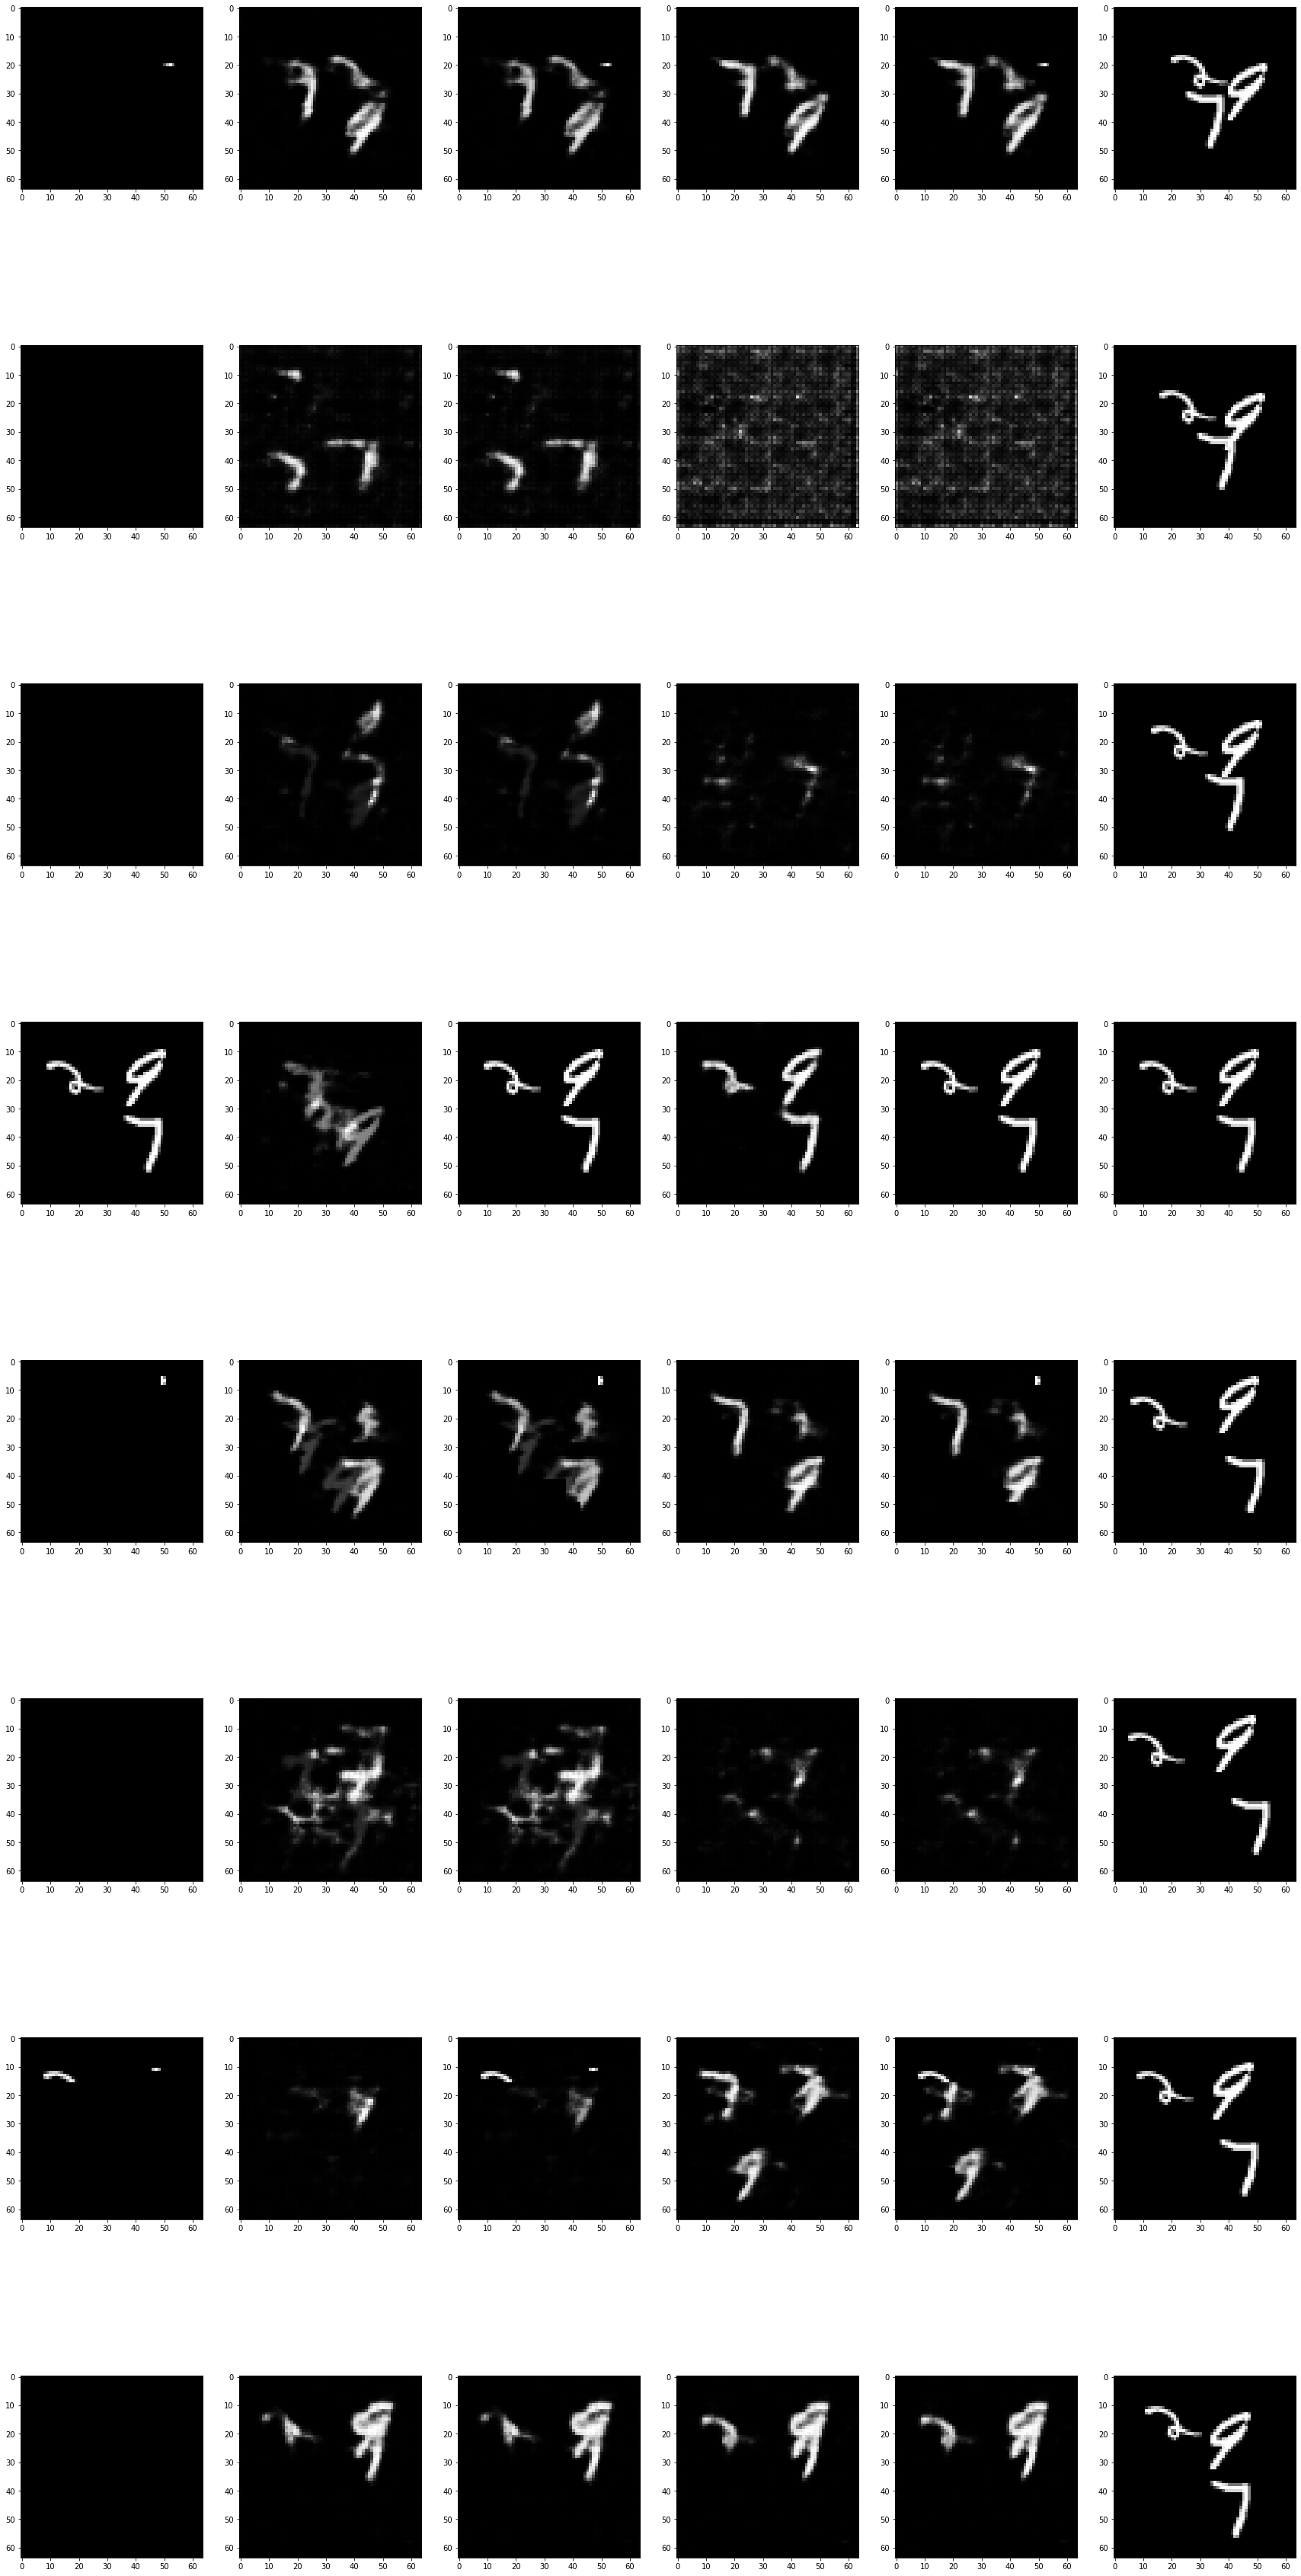

In [123]:
one = np.random.randint(len(x_val_miss))

one = 2

x = x_val_miss[one].to(device)
mask = m_val_miss[one].to(device)

input = torch.cat((x,mask),dim=1).unsqueeze(0)
y_origin = x_val_full[one].to(device)

(pi, mu, sigma),predicts, imputation,latents = model(input)



predicts_v = vae.decoder(latents.squeeze()).mean

imputated_result = predicts_v*(1-mask)+input[0][:,:1,:]*mask
# y_preds = [torch.normal(mu, sigma)[:, :, i, :] for i in range(n_gaussians)]

# y_preds=torch.sum((torch.normal(mu, sigma)*pi),dim=2)

# y_preds  = torch.normal(mu, sigma).gather(2,pi.max(2)[1].unsqueeze(2)).squeeze(2)

# pi_t=pi.transpose(2, 3)
# pi_t_r=pi_t.reshape(pi_t.size(0)*pi_t.size(1)*pi_t.size(2),pi_t.size(3))
# k = torch.multinomial(pi_t_r, 1).view(-1)
# k_r = k.reshape(pi_t.size(0),pi_t.size(1),pi_t.size(2)).unsqueeze(2)
# y_preds = torch.normal(mu, sigma).gather(2,k_r).squeeze(2)

# compare_result=torch.cat([x,y]+y_preds)
fig, axs = plt.subplots(seqlen, 6,figsize=(30,seqlen*8))
for index in range(seqlen):
    vae.decoder.eval()
    with torch.no_grad():
        
        # imputed_img =imputation[0][index][0]
        imputed_img = imputated_result[index][0]
        predict_img =predicts[0][index][0]
        im_img =imputation[0][index][0]
        axs[index,0].imshow(x[index][0].cpu().squeeze().numpy(), cmap='gray')
        axs[index,1].imshow(predict_img.cpu().squeeze().numpy(), cmap='gray')
        axs[index,2].imshow(im_img.cpu().squeeze().numpy(), cmap='gray')
        axs[index,3].imshow(predicts_v[index][0].cpu().squeeze().numpy(), cmap='gray')
        axs[index,4].imshow(imputed_img.cpu().squeeze().numpy(), cmap='gray')
        axs[index,5].imshow(y_origin[index][0].cpu().squeeze().numpy(), cmap='gray')
# for z_result in compare_result:
#     vae.decoder.eval()
#     with torch.no_grad():
#         d_image=vae.decoder(z_result)
#         plt.imshow(d_image.cpu().squeeze().numpy(), cmap='gray')
#         plt.show()

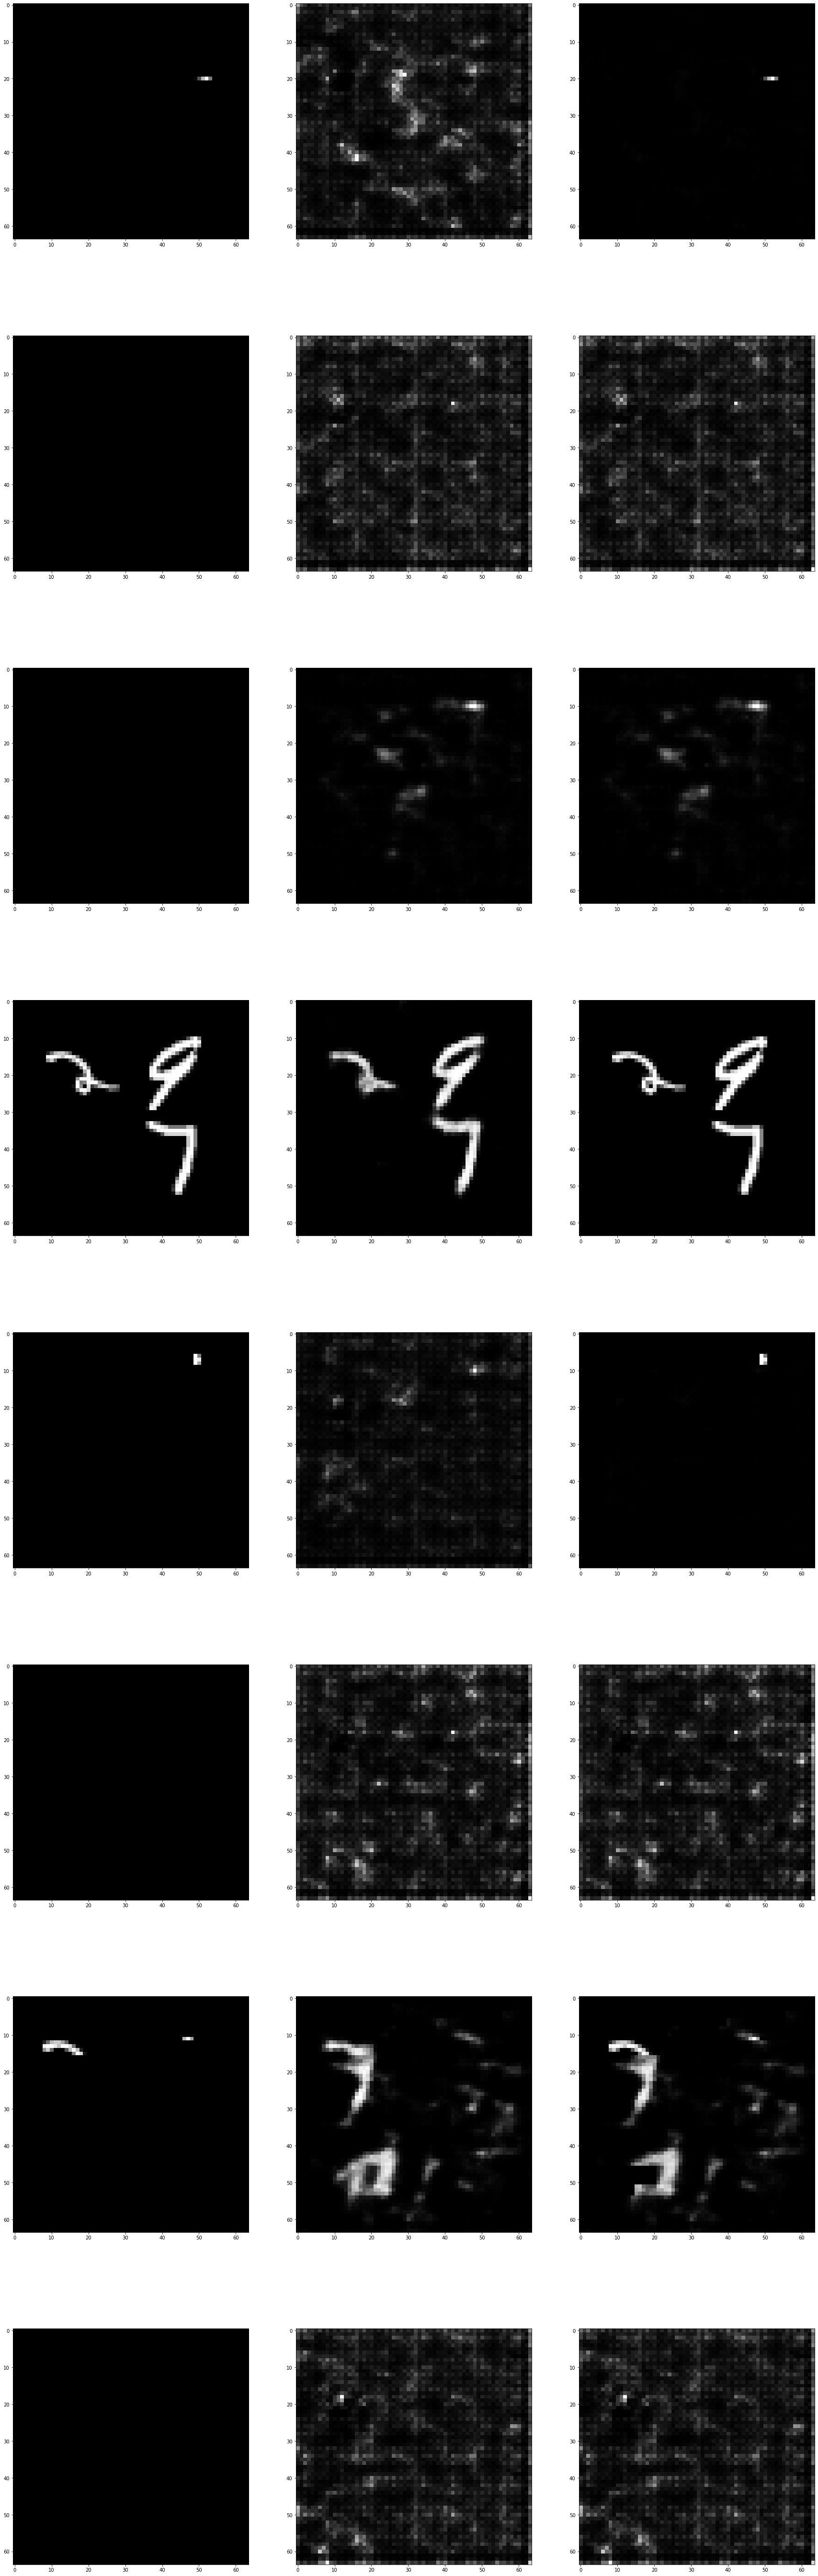

In [124]:
one = np.random.randint(len(x_val_miss))

one = 2

x = x_val_miss[one].to(device)
mask = m_val_miss[one].to(device)

input = torch.cat((x,mask),dim=1)
y_origin = x_val_full[one].to(device)

fig, axs = plt.subplots(8, 3,figsize=(30,100))
for index in range(input.size(0)):
   
    img = input[index][:1].unsqueeze(0).to(device)
    
    img_mask = input[index][1:].unsqueeze(0).to(device)
   
    vae.encoder.eval()
    vae.decoder.eval()
    with torch.no_grad():
        rec_img  = vae.decoder(vae.encoder(img)).mean
    imputated_result = rec_img*(1-img_mask)+img*img_mask
    axs[index,0].imshow(img.cpu().squeeze().numpy(), cmap='gray')
    axs[index,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')
    axs[index,2].imshow(imputated_result.cpu().squeeze().numpy(), cmap='gray')